# Projet 3: Descente de gradient stochastique

##Préliminaires

### Importation des packages

In [1]:
from math import *
import random
import numpy as np
from numpy.random import multivariate_normal, randn # Probability distributions on vectors

import pandas as pd  #pandas pour la gestion des données 
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error


### Génération de la base de données

J'ai décidé de travailler sur un dataset que j'ai généré aléatoirement composé de 6 variables décorrélées. 
Connaissant les coefficients de régression, il est aussi plus simple de s'assurer du bon fonctionnement de la méthode et de l'implémentation de l'algorithme de descente de gradient.

In [2]:
np.random.seed(4)
n=1000
nbr_var=6
x=np.zeros((n,nbr_var))
sd=10
mu=50
for i in range(nbr_var):
  x[:,i]= np.random.randn(n)*sd+mu
design=pd.DataFrame(x,columns = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6'])
coef=np.array([6,4,0.8,0.02,7,3.8]).reshape(-1,1)
y=np.dot(design,coef)+np.random.randn(n).reshape(-1,1)

In [3]:
dataset=design
dataset

,X1,X2,X3,X4,X5,X6
0,50.505617,48.696894,50.295385,40.192077,64.293718,52.412063
1,54.999513,31.111271,44.140924,58.286383,47.378074,42.620170
2,40.040911,31.057035,53.082340,66.513806,56.034249,54.876799
3,56.935985,42.358665,58.081081,43.839962,47.762371,41.660726
4,45.816985,58.248199,51.340520,46.276674,46.635936,57.481332
...,...,...,...,...,...,...
995,48.325473,40.090112,42.060183,37.207292,59.217622,59.130322
996,66.809791,45.170529,43.691978,35.219584,54.505177,48.683805
997,41.714710,53.582580,67.778976,54.752323,62.686795,68.366000
998,53.693850,50.323201,42.637406,58.305153,64.310586,61.257871


Nous obtenons la matrice de corrélation suivante.

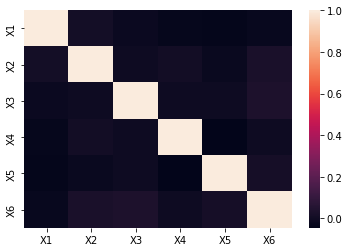

In [4]:

#Matrice de corrélation
corrMatrix = dataset.corr()
sn.heatmap(corrMatrix, annot=False)
plt.show()

### Séparation du training et du test set

In [5]:
#Séparation du training set et du test set
X_train,X_test,y_train,y_test=train_test_split(design,y,test_size=0.33, random_state=1)



### Détermination de la borne supérieure pour le learningrate

In [6]:
#Plus grand valeur propre de la matrice de XX.T
max_ev=max(np.linalg.eigvals(np.dot(X_train.T, X_train))).real
min_ev=min(np.linalg.eigvals(np.dot(X_train.T, X_train))).real
# Nous obtenons la borne supérieur du pas que nous pouvons utilisant grace au résulat théorique suivant 
step=1/max_ev
step

9.914984017788875e-08

In [7]:
min_ev

59268.91510975949

In [8]:
# Définition de la fonction de perte
def ridge_error(y,X,beta,lambd):

  return(((np.dot(X,beta)-y)**2).sum()/2+lambd*(beta**2).sum()/2)/len(y)

In [9]:
def gradient_descent_ridge(X, y,lambd, learningrate=1e-3, epochs=10000,epsilon=1e-2,monit=True,arret=True):
    """
  Algorithme de descent de gradient avec pénalité ridge
  
  Parametres
  ----------
  X : np.array
    matrice de design

  y : np.array
    vecteur du target

  lambd: float
    parametre de régularisation

  epochs: int
    Nombre d'epochs


  monit : bool
      Affiche l'itération en cours


  
  arret : bool
      Algorithme s'arrete lorsque la condition d'arret est satisfaite
  
  std : float, default=1.
      Standard-deviation of the noise

  epsilon : float
      Paramètre de précision pour la condition d'arret
  """  
    ridge=[]
    beta = pd.DataFrame([0,0,0,0,0,0]) # Initialisation des coefficients
    for i in range(epochs+1):
      if i%(epochs/100)==0 and monit: #monitoring
        print("itération {} en cours ...".format(i))
      # Updating beta
      delta =  np.subtract(np.dot(X,beta),y.reshape(-1,1))
      gradient=np.dot(X.T,delta)+ lambd*beta
      beta_new= beta-learningrate * gradient # on retire un gradient
      ridge.append(ridge_error(y,X,beta_new,lambd)) # on calcule l'erreur
      
      if np.linalg.norm(gradient)<epsilon and arret: #condition d'arrêt
        print("L'algorithme a convergé ")
        break
      beta=beta_new
     
    return beta,ridge

## Question 1

### Algorithme de descente de gradient stochastique

In [10]:
batch_size=1
def gradient_stochastique_descent_ridge(X, y,lambd, learningrate=step, iters=1000,epsilon=1e-4, batch_size=batch_size,monit=True,arret=True):
    ridge=[]
    n=np.shape(X)[0]
    X=np.array(X)
    beta = np.array([0,0,0,0,0,0]).reshape(-1,1) # Initialisation des coefficients
    
    for i in range(iters):
      
      # Updating beta
      ind=np.random.randint(0,n-1,batch_size) # On choisit les indices sur lesquels on effectue la descente de gradient aléatoirement
      X_ind=np.array([X[i] for i  in ind ])
      y_ind=np.array([y[i] for i  in ind ]).reshape(-1,1)
      delta =  np.dot(X_ind,beta)-y_ind
      gradient=np.add(np.dot(X_ind.T,delta) , lambd*beta) # On calcule le gradient
      beta_new= beta-learningrate * gradient # on retire un gradient
      ridge.append(ridge_error(y,X,beta_new,lambd))
      if monit :
        print("itération {} en cours ...".format(i))
      if np.linalg.norm(gradient)<epsilon and arret: #Condition d'arrêt
        print("L'algorithme a convergé ")
        break
      beta=beta_new
     
    return beta,ridge


### Vitesse de convergence de l'algorithme

Nous tracons le graphique de la log fonction de perte en fonction du nombre d'itérations. Nous pouvons ainsi observer la vitesse de convergence.


Text(0.5, 1.0, "Fonction de perte ridge en fonction du nombre d'itération")

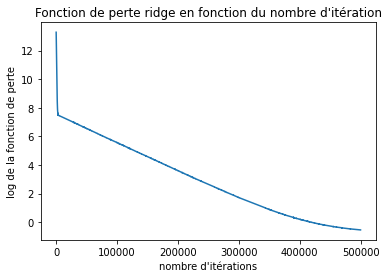

In [ ]:

beta_sto,ridge_sto=gradient_stochastique_descent_ridge(X_train,y_train,lambd=0,learningrate=1*step, batch_size=1,iters=500000,monit=False)
plt.plot(np.log(ridge_sto))
plt.xlabel("nombre d'itérations")
plt.ylabel("log de la fonction de perte")
plt.title("Fonction de perte ridge en fonction du nombre d'itération")

In [ ]:
beta_sto

array([[5.96723138],
       [4.0078377 ],
       [0.82327477],
       [0.04201116],
       [6.97983696],
       [3.80071965]])

Le gradient stochastique converge en plus d'itération que le gradient classique mais il est aussi beaucoup plus rapide en terme de calculs car il n'accède qu'a une seule donnée pour chaque itération alors que le gradient classique accède aux n observations à chaque itération.
De plus le gradient stochastique à tendance à converger vers un voisinage de la solution et à avoir une forte variance

Text(0.5, 1.0, "Fonction de perte ridge en fonction du nombre d'itération")

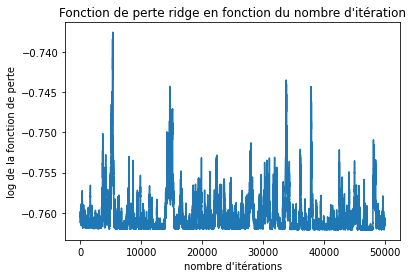

In [ ]:
#beta_sto,ridge_sto=gradient_stochastique_descent_ridge(X_train,y_train,lambd=0,learningrate=2*step, batch_size=1,epochs=100,monit=False,arret=False)
plt.plot(np.log(ridge_sto)[450000:])
plt.xlabel("nombre d'itérations")
plt.ylabel("log de la fonction de perte")
plt.title("Fonction de perte ridge en fonction du nombre d'itération")

En zoomant sur la courbe on peut observer des oscillations.

### Descente de gradient vs gradient stochastique (Vitesse de convergence)

Dans cette partie nous allons comparer le gradient stochastique et la descente de gradient classique pour un même stepsize.

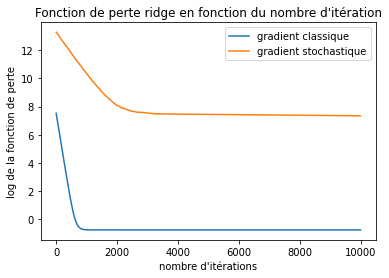

In [ ]:
n=np.shape(X_train)[0]
beta,ridge=gradient_descent_ridge(X_train,y_train,lambd=0,learningrate=step,epochs=10000,arret=False, monit=False)
beta_sto,ridge_sto=gradient_stochastique_descent_ridge(X_train,y_train,lambd=0,learningrate=step, iters=10000,batch_size=1,arret=False, monit=False)
plt.plot(np.log(ridge)[1:],label="gradient classique")
plt.plot(np.log(ridge_sto)[1:],label="gradient stochastique")
plt.xlabel("nombre d'itérations")
plt.ylabel("log de la fonction de perte")
plt.legend()
plt.title("Fonction de perte ridge en fonction du nombre d'itération")
plt.show()

Le gradient classique a une courbe lisse.

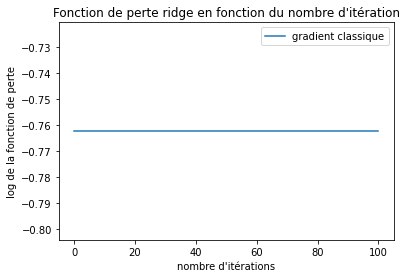

In [ ]:
plt.plot(np.log(ridge)[9900:],label="gradient classique")

plt.xlabel("nombre d'itérations")
plt.ylabel("log de la fonction de perte")
plt.legend()
plt.title("Fonction de perte ridge en fonction du nombre d'itération")
plt.show()

Le gradient stochastique a une courbe qui oscille.

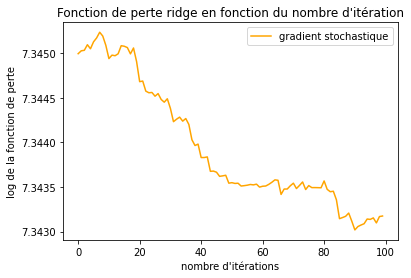

In [ ]:
plt.plot(np.log(ridge_sto)[9900:],label="gradient stochastique",c='orange')
plt.xlabel("nombre d'itérations")
plt.ylabel("log de la fonction de perte")
plt.legend()
plt.title("Fonction de perte ridge en fonction du nombre d'itération")
plt.show()

Nous pouvons observer les résultats suivants:
- la descente de gradient stochastique est plus rapide en temps d'exécution que la descente de gradient classique
- la descent de gradient stochastique donne un bon résultat pour l'estimation des patramètres
-la descente de gradient stochastique a une forte variance.

D'après la théorie , la descente de gradient stochastique a une forte variance comparée à la descente de gradient classsique. On peut observer ce résultat expérimentalement. 

La courbe du gradient stochastique oscille contrairement à celle du gradient classique. Une méthode pour limiter cette variance est d'utiliser l'algorithme de batch stochastique gradient. Cet algorithme est un compromis entre la descente de gradient stochastique et la descente de gradient classique. En effet, au lieu de calculer le gradient stochastique sur une seule observation nous allons le calculer sur plusieurs observations. Le nombre d'observations utilisées pour calculer le gradient est appelé batch size. Remarquons que lorsque le batch size est égal à n (le nombre d'observations), on retrouve le gradient classique.

## Question 2

Dans cette partie nous cherchons à trouver le bon compromis entre la descente de gradient classique et la descente de gradient stochastique en utilisant le batch stochastique gradient.

On crée une liste de batch size grossière, nous l'affinerons par la suite.

In [ ]:
BS=range(1,20,3)
list(BS)

[1, 4, 7, 10, 13, 16, 19]

<function matplotlib.pyplot.show(*args, **kw)>

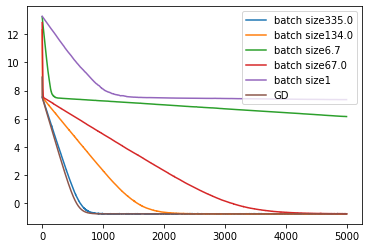

In [ ]:
n=np.shape(X_train)[0]
from math import *
BS=[n/2,n/5,n/100,n/10,1]
error_test=[]
plt.figure()
for batch_size in BS:
  beta,ridge=gradient_stochastique_descent_ridge(X_train,y_train,lambd=0,learningrate=2*step,batch_size=ceil(batch_size),epochs=5000,monit=False,arret=False)
  plt.plot(np.log(ridge),label='batch size'+str(batch_size))
beta,ridge=gradient_descent_ridge(X_train,y_train,lambd=0,learningrate=1.1*step,epochs=5000,monit=False,arret=False)
plt.plot(np.log(ridge),label='GD')
plt.legend()
plt.show


On peut observer sur le graphique ci-dessus qu'on arrive à la convergence avec quasiment le même nombre d'itérations que pour la descente de gradient classique avec un batch size de $\frac{n}{2}$.

 C'est à dire qu'avec 2 fois moins d'accès aux données, on a le même résultat qu'avec la descente de gradient classique. 
 
 Pour un batch size de $\frac{n}{5}$, il faut 2 fois plus d'itérations mais 5 fois moins d'accès aux données et pour un batch size de $\frac{n}{10}$ il faut 4 fois plus d'itérations pour 10 fois moins d'accès aux données. 
 On peut donc choisir un batch size de $\frac{n}{2}$ . 
 
 Pour trouver rigoureusementle batch size optimal, il faudrait calculer le cout de calcul relatif d'une itération supplémentaire par rapport à la réduction du nombre d'accès aux données.

## Question 3: Advanced stochastique gradient 

Nous allons implémenter l'algorithme SVRG Stochastic Variance-Reduced Gradient. Avec cette méthode la variance est réduite car nous calculons un gradient complet arès chaque cycle de m sous-itérations 

In [21]:
def SVRG(X, y,lambd, learningrate=1e-7,m_=10, iters=1000,epsilon=1e-2,monit=True,arret=True):
    ridge=[]
    n=np.shape(X)[0]
    X=np.array(X)
    beta = np.array([0,0,0,0,0,0]).reshape(-1,1) # Initialisation des coefficients
    for i in range(iters):
      if monit and i%(iters/100)==0 : #monitoring
        print("itération {} en cours ...".format(i))
      # calcul full gradient
      delta =  np.subtract(np.dot(X,beta),y.reshape(-1,1))
      gradient=(np.dot(X.T,delta)+ lambd*beta)
      beta_tilde=beta
      #beta_new= beta-learningrate * gradient # on retire un gradient
      choix_beta=[]
      for ii in range(m_):
        ind=random.randint(0,n-1) # On choisit les indices sur lesquels on effectue la descente de gradient aléatoirement
        X_ind=X[ind].reshape(1,-1)
        y_ind=y[ind] .reshape(-1,1)
        gradient_ii =  np.add(np.dot(X_ind.T,np.dot(X_ind,beta)-y_ind) , lambd*beta) # On calcule le gradient stochastique au point beta
        gradient_ii_tilde=np.add(np.dot(X_ind.T,np.dot(X_ind,beta_tilde)-y_ind) , lambd*beta_tilde) # On calcule le gradient stochastique au point beta_tilde
        g_tilde=gradient_ii_tilde-gradient_ii+gradient # On calcule g_tilde qui va etre utiliser comme direction de descente pour mettre à jour beta_tilde
        beta_tilde=beta_tilde - learningrate* g_tilde
        choix_beta.append(beta_tilde)
      choix=random.randint(0,m_-1) # On choisit l'indice entre 0 et m_ de la valeur de beta que l'on choisit
      beta=choix_beta[choix] 
      
      ridge.append(ridge_error(y,X,beta,lambd))
      
      if np.linalg.norm(gradient)<epsilon and arret: #condition d'arrêt
        print("L'algorithme a convergé ")
        break
      
     
    return beta,ridge

In [36]:
beta_svrg,erreur_svrg=SVRG(X_train, y_train,lambd=0, learningrate=(0.7*step),m_=5, iters=1000,epsilon=1e-2,monit=False,arret=True)

La solution de SVRG est:

In [37]:
beta_svrg

array([[5.99731749],
       [4.00016591],
       [0.79463008],
       [0.02268103],
       [7.00286685],
       [3.80335464]])

Une prédiction très proche  des coefficients réels:

In [26]:
coef

array([[6.  ],
       [4.  ],
       [0.8 ],
       [0.02],
       [7.  ],
       [3.8 ]])

<function matplotlib.pyplot.show(*args, **kw)>

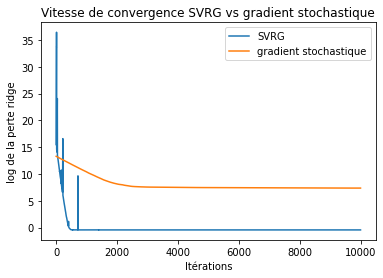

In [38]:

plt.figure()
beta,ridge=SVRG(X_train, y_train,lambd=2, learningrate=step,m_=5, iters=10000,epsilon=1e-2,monit=False,arret=False)
plt.plot(np.log(ridge),label='SVRG')
beta,ridge=gradient_stochastique_descent_ridge(X_train, y_train,lambd=2, learningrate=step,batch_size=1, iters=10000,epsilon=1e-2,monit=False,arret=False)
plt.plot(np.log(ridge),label='gradient stochastique')
plt.title('Vitesse de convergence SVRG vs gradient stochastique')
plt.ylabel('log de la perte ridge')
plt.xlabel('Itérations')
plt.legend()
plt.show

SVRG a une bien meilleur convergence mais il est également plus couteux.